In [1]:
#!pip install torch --quiet
#!pip install gpytorch --quiet

In [2]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import math
#import torch
#import gpytorch
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
import sklearn.gaussian_process as gp


In [3]:
training_data = pd.read_csv('../../data/2-uw_layer1_trainingdata.csv')

In [4]:
training_data.head()

,BOREHOLE_ID,BOREHOLE_NAME,BOREHOLE_TYPE,BOREHOLE_DEPTH_FT,ELEVATION_FT,LATITUDE,LONGITUDE,LAYER_NUMBER,TOP_DEPTH_FT,BOTTOM_DEPTH_FT,USCS,SIMPLE_USCS,LAYER_THICKNESS_FT,geometry,MAPPED_UNIT,SLOPE,ROUGHNESS
0,7138,B-1,Geotechnical,20.3,167.8,47.656719,-122.305728,1,0.0,1.0,SP,S,1.0,POINT (-122.30572826225551 47.65671910427262),Qvt,3.668571,18.199593
1,7143,B-1-92,Geotechnical,48.5,123.2,47.653642,-122.306837,1,0.0,1.0,ML,M,1.0,POINT (-122.30683733651996 47.653641992071),Qvt,2.222722,10.232103
2,7144,B-2-92,Geotechnical,42.5,122.9,47.653766,-122.306468,1,0.0,1.0,ML,M,1.0,POINT (-122.30646818846918 47.653765607387086),Qvt,1.996012,9.385303
3,7145,B-3-92,Geotechnical,43.0,117.3,47.653256,-122.306638,1,0.0,1.0,ML,M,1.0,POINT (-122.30663757111256 47.65325573559402),Qvt,3.011285,14.187020
4,7146,B-4-92,Geotechnical,43.0,123.4,47.653709,-122.306259,1,0.0,0.5,SM,S,0.5,POINT (-122.30625929325416 47.65370851868135),Qvt,1.996012,9.385303


<Axes: >

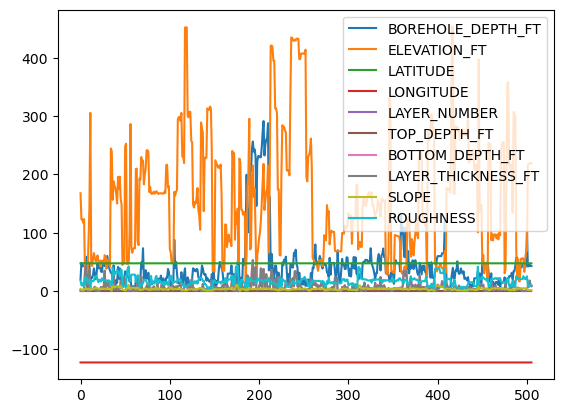

In [5]:
training_data.drop(columns=['BOREHOLE_ID']).plot()

In [6]:
#training_data.boxplot(column='LAYER_THICKNESS_FT', by='USCS')

In [7]:
#training_data.boxplot(column='SLOPE', by='USCS')

In [8]:
#training_data.boxplot(column='ROUGHNESS', by='USCS')

In [9]:
#training_data.boxplot(column='LAYER_THICKNESS_FT', by='SIMPLE_USCS')

In [10]:
#training_data.boxplot(column='SLOPE', by='SIMPLE_USCS')

In [11]:
#training_data.boxplot(column='ROUGHNESS', by='SIMPLE_USCS')

one-hot-encoding for MAPPED_UNIT feature

In [12]:
# with sklearn function
#enc = OneHotEncoder(handle_unknown='ignore')
#encoded_mapped_unit = enc.fit_transform(training_data[['MAPPED_UNIT']]).toarray()


In [13]:
## Preprocessing
#preprocessor = ColumnTransformer(
#    transformers=[
#        ('cat', OneHotEncoder(), ['MAPPED_UNIT']),  # One-hot encode categorical features
#        ('num', StandardScaler(), ['SLOPE', 'ROUGHNESS'])  # Standardize numerical features
#    ])
#
## Apply transformations and convert to dense array
#training_data_processed = preprocessor.fit_transform(training_data).toarray()  # Convert to array if sparse

In [14]:
#training_data.keys()

In [15]:
#training_data_processed = pd.DataFrame(training_data_processed)

In [16]:
#training_data_processed

In [17]:
# for the classification model
#X_c = training_data_processed.drop(columns=[11,12])
#y_c = training_data_processed['SIMPLE_USCS']

## for the regression model
#X_r = training_data_encoded.drop(columns=['BOREHOLE_ID', 'BOREHOLE_NAME', 'BOREHOLE_TYPE', 'BOREHOLE_DEPTH_FT',
#       'ELEVATION_FT', 'LATITUDE', 'LONGITUDE', 'LAYER_NUMBER', 'TOP_DEPTH_FT',
#       'BOTTOM_DEPTH_FT', 'SIMPLE_USCS', 'USCS', 'LAYER_THICKNESS_FT',
#       'geometry'])
#y_r = training_data_encoded['LAYER_THICKNESS_FT']

In [38]:
# with pandas, seems simpler
training_data_encoded = pd.get_dummies(training_data, columns = ['MAPPED_UNIT'], dtype=int)

# scalers
slope_scaler = StandardScaler()
roughness_scaler = StandardScaler()
layer_thickness_scaler = StandardScaler()
elevation_scaler = StandardScaler()


training_data_encoded['SLOPE'] = slope_scaler.fit_transform(pd.DataFrame(training_data_encoded['SLOPE']))
training_data_encoded['ROUGHNESS'] = roughness_scaler.fit_transform(pd.DataFrame(training_data_encoded['ROUGHNESS']))
training_data_encoded['LAYER_THICKNESS_FT'] = layer_thickness_scaler.fit_transform(pd.DataFrame(training_data_encoded['LAYER_THICKNESS_FT']))
training_data_encoded['ELEVATION_FT'] = layer_thickness_scaler.fit_transform(pd.DataFrame(training_data_encoded['ELEVATION_FT']))
training_data_encoded['LATITUDE'] = layer_thickness_scaler.fit_transform(pd.DataFrame(training_data_encoded['LATITUDE']))
training_data_encoded['LONGITUDE'] = layer_thickness_scaler.fit_transform(pd.DataFrame(training_data_encoded['LONGITUDE']))




# labelers
simple_uscs_encoder = LabelEncoder()

training_data_encoded['SIMPLE_USCS'] = simple_uscs_encoder.fit(training_data_encoded['SIMPLE_USCS'])
print(simple_uscs_encoder.classes_)

['C' 'G' 'M' 'O' 'P' 'S']


In [39]:
training_data_encoded.head()

,BOREHOLE_ID,BOREHOLE_NAME,BOREHOLE_TYPE,BOREHOLE_DEPTH_FT,ELEVATION_FT,LATITUDE,LONGITUDE,LAYER_NUMBER,TOP_DEPTH_FT,BOTTOM_DEPTH_FT,...,MAPPED_UNIT_Ql,MAPPED_UNIT_Qp,MAPPED_UNIT_Qpf,MAPPED_UNIT_Qpo,MAPPED_UNIT_Qva,MAPPED_UNIT_Qvi,MAPPED_UNIT_Qvr,MAPPED_UNIT_Qvt,MAPPED_UNIT_Qw,MAPPED_UNIT_wtr
0,7138,B-1,Geotechnical,20.3,0.057875,-0.565928,0.899960,1,0.0,1.0,...,0,0,0,0,0,0,0,1,0,0
1,7143,B-1-92,Geotechnical,48.5,-0.371846,-0.758805,0.817198,1,0.0,1.0,...,0,0,0,0,0,0,0,1,0,0
2,7144,B-2-92,Geotechnical,42.5,-0.374737,-0.751057,0.844744,1,0.0,1.0,...,0,0,0,0,0,0,0,1,0,0
3,7145,B-3-92,Geotechnical,43.0,-0.428693,-0.783017,0.832105,1,0.0,1.0,...,0,0,0,0,0,0,0,1,0,0
4,7146,B-4-92,Geotechnical,43.0,-0.369919,-0.754635,0.860333,1,0.0,0.5,...,0,0,0,0,0,0,0,1,0,0


In [40]:
# for the classification model
X_c = training_data_encoded.drop(columns=['BOREHOLE_ID', 'BOREHOLE_NAME', 'BOREHOLE_TYPE', 'BOREHOLE_DEPTH_FT',
       'ELEVATION_FT', 
       'LATITUDE', 'LONGITUDE', 'LAYER_NUMBER', 'TOP_DEPTH_FT',
       'BOTTOM_DEPTH_FT', 'SIMPLE_USCS', 'USCS', 'LAYER_THICKNESS_FT',
       'geometry'])
y_c = training_data_encoded['SIMPLE_USCS']

# for the regression model
X_r = training_data_encoded.drop(columns=['BOREHOLE_ID', 'BOREHOLE_NAME', 'BOREHOLE_TYPE', 'BOREHOLE_DEPTH_FT',
       'ELEVATION_FT', 
        'LATITUDE', 'LONGITUDE', 'LAYER_NUMBER', 'TOP_DEPTH_FT',
       'BOTTOM_DEPTH_FT', 'SIMPLE_USCS', 'USCS', 'LAYER_THICKNESS_FT',
       'geometry'])
y_r = training_data_encoded['LAYER_THICKNESS_FT']

In [41]:
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_c, y_c, test_size=0.2, random_state=42)

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_r, y_r, test_size=0.2, random_state=42)


In [42]:
myGPR = gp.GaussianProcessRegressor()

myGPR.fit(X_train_r, y_train_r)

GaussianProcessRegressor()

In [48]:
myGPC = gp.GaussianProcessClassifier(multi_class='one_vs_rest')

myGPC.fit(X_train_c, y_train_c)

TypeError: '<' not supported between instances of 'LabelEncoder' and 'LabelEncoder'

In [34]:
y_train_c

477    S
15     S
332    S
423    M
19     G
      ..
106    S
270    S
348    M
435    S
102    M
Name: SIMPLE_USCS, Length: 404, dtype: object

In [35]:
y_predicted_c = myGPR.predict(X_test_c)

In [37]:
myGPR.classes_

AttributeError: 'GaussianProcessRegressor' object has no attribute 'classes_'

In [36]:
y_predicted_c

array([ 3.95278931e-01, -1.97076416e+00, -2.16590881e-01,  9.02633667e-02,
       -2.16590881e-01,  1.41543121e+01, -4.93316650e-02, -4.93103027e-01,
        1.00718689e+00, -2.62226105e-01, -1.72373199e+00, -2.56423950e-01,
       -2.07061768e-01, -3.69369507e-01,  2.43957520e-01, -1.47020493e+01,
        9.30786133e-02,  2.22717285e-01,  3.03222656e-01, -2.39387512e-01,
        2.69958496e-01, -1.71543121e-01,  3.97766113e-01,  6.07894897e-01,
       -2.55990601e+00, -1.47020493e+01,  3.59463359e+01, -3.77693176e-01,
        2.38952637e-01, -2.16590881e-01, -7.47093201e-01, -4.93316650e-02,
       -5.25283813e-02,  3.32641602e-01, -1.52507782e-01,  5.08529663e-01,
       -2.98614502e-01,  2.94692993e-01,  2.15820312e-01,  9.02633667e-02,
       -2.62226105e-01, -2.98614502e-01,  3.86169434e-01, -6.77978516e-01,
        1.14134979e+00, -3.12321854e+00,  3.97766113e-01,  3.15673828e-01,
       -1.52507782e-01, -3.20358276e-01, -3.90549469e+00, -6.52465820e-02,
        1.88751221e-01, -

In [109]:
myGPR.fit(X_train_r, y_train_r)

GaussianProcessRegressor()

In [110]:
y_predicted_r = myGPR.predict(X_test_r)

In [111]:
y_test_r.shape

(102,)

(array([ 2., 95.,  2.,  1.,  0.,  0.,  0.,  0.,  1.,  1.]),
 array([-0.0535524 , -0.01713217,  0.01928806,  0.05570829,  0.09212852,
         0.12854875,  0.16496898,  0.20138921,  0.23780944,  0.27422967,
         0.3106499 ]),
 <BarContainer object of 10 artists>)

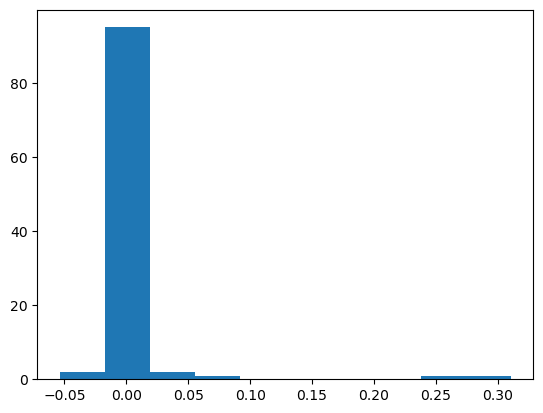

In [112]:
residuals = y_test_r-y_predicted_r
plt.hist(residuals)

(array([39., 29., 12.,  9.,  3.,  2.,  2.,  1.,  1.,  4.]),
 array([-0.91229427, -0.46715807, -0.02202186,  0.42311434,  0.86825055,
         1.31338675,  1.75852295,  2.20365916,  2.64879536,  3.09393157,
         3.53906777]),
 <BarContainer object of 10 artists>)

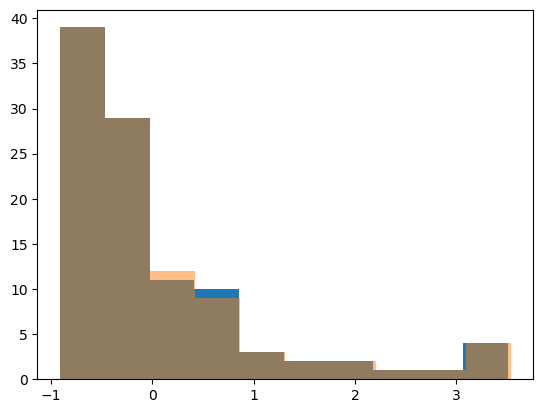

In [113]:
plt.hist(y_test_r)
plt.hist(y_predicted_r,alpha=0.5)

In [114]:
y_predicted_r.shape

(102,)

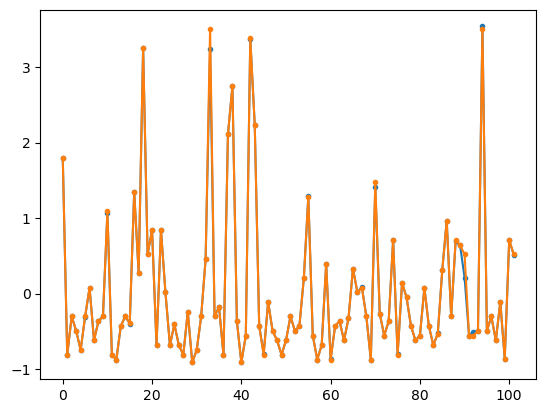

In [115]:
plt.plot(y_predicted_r, '.-')
plt.plot(y_test_r.to_numpy(),'.-')
#plt.ylim(-1000,1000)

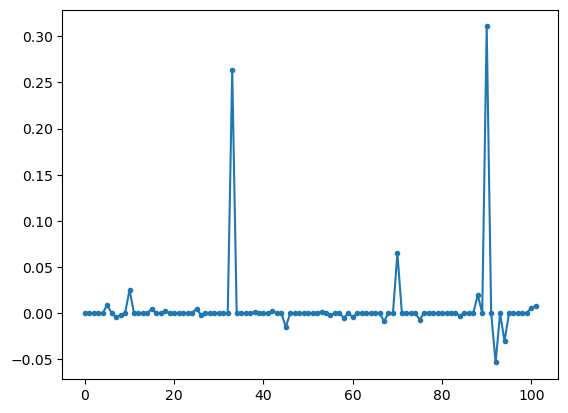

In [116]:
plt.plot(residuals.to_numpy(), '.-');
